In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html


In [2]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 5609, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 5609 (delta 50), reused 62 (delta 33), pack-reused 5492
Receiving objects: 100% (5609/5609), 12.02 MiB | 12.19 MiB/s, done.
Resolving deltas: 100% (4078/4078), done.
/home/neto/projects/tcc/mmsegmentation
Obtaining file:///home/neto/projects/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [4]:
!unzip ../segmentationV2.zip

Archive:  ../segmentationV2.zip
   creating: segmentation/
   creating: segmentation/annotations/
  inflating: segmentation/annotations/image005-roi4.jpg  
  inflating: segmentation/annotations/image021-roi4.jpg  
  inflating: segmentation/annotations/image021-roi5.jpg  
  inflating: segmentation/annotations/image006-2-roi3.jpg  
  inflating: segmentation/annotations/image058-roi4.jpg  
  inflating: segmentation/annotations/image005-2-roi3.jpg  
  inflating: segmentation/annotations/image006-roi5.jpg  
  inflating: segmentation/annotations/image058-roi5.jpg  
  inflating: segmentation/annotations/image032-roi1.jpg  
  inflating: segmentation/annotations/image024-roi4.jpg  
  inflating: segmentation/annotations/image058-roi7.jpg  
  inflating: segmentation/annotations/image005-roi3.jpg  
  inflating: segmentation/annotations/image023-roi3.jpg  
  inflating: segmentation/annotations/image062-roi2.jpg  
  inflating: segmentation/annotations/image020-roi3.jpg  
  inflating: segmentation/an

  inflating: segmentation/images/image032-roi4.jpg  
  inflating: segmentation/images/image058-roi6.jpg  
  inflating: segmentation/images/image024-roi2.jpg  
  inflating: segmentation/images/image008-roi3.jpg  
  inflating: segmentation/images/image038-roi1.jpg  
  inflating: segmentation/images/image037-roi2.jpg  
  inflating: segmentation/images/image004-roi3.jpg  
  inflating: segmentation/images/image050-roi2.jpg  
  inflating: segmentation/images/image061-roi4.jpg  
  inflating: segmentation/images/image004-roi4.jpg  


In [5]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [6]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

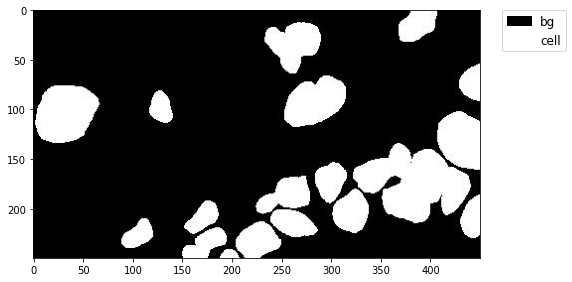

In [7]:
# Let's take a look at the segmentation map we got

img = Image.open('segmentation/annotations/image003-2-roi1.jpg')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [8]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.jpg')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [9]:
@DATASETS.register_module()
class TestDataSetResize(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.jpg', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [15]:
cfg = Config.fromfile('configs/unet/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes.py')

In [16]:
# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.pretrained = None

cfg.model.backbone.norm_cfg = cfg.norm_cfg
# cfg.model.backbone.depth = 18

# cfg.model.decode_head.in_channels = 250
# cfg.model.decode_head.channels = 128

# cfg.model.auxiliary_head.in_channels = 450
# cfg.model.auxiliary_head.in_channels = 112

cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'TestDataSetResize'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

# cfg.crop_size = (250, 450)
# cfg.train_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(type='LoadAnnotations'),
#     dict(type='RandomFlip', flip_ratio=0.5),
#     dict(type='DefaultFormatBundle'),
#     dict(type='Collect', keys=['img', 'gt_semantic_seg']),
# ]

# cfg.test_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(
#         type='MultiScaleFlipAug',
#         img_scale=(250, 450),
#         flip=False,
#         transforms=[
#             dict(type='ImageToTensor', keys=['img']),
#             dict(type='Collect', keys=['img']),
#         ])
# ]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=64,
        in_index=4,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type=

In [17]:
datasets = [build_dataset(cfg.data.train)]

2022-01-11 12:05:46,097 - mmseg - INFO - Loaded 96 images


In [18]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [19]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-01-11 12:05:48,006 - mmseg - INFO - Loaded 24 images
2022-01-11 12:05:48,007 - mmseg - INFO - Start running, host: neto@Matheus-Neto, work_dir: /home/neto/projects/tcc/mmsegmentation/work_dirs/tutorial
2022-01-11 12:05:48,007 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 3.94 GiB total capacity; 2.30 GiB already allocated; 690.88 MiB free; 2.30 GiB reserved in total by PyTorch)

In [ ]:
datasets[0].__getitem__(0)